# Import packages

In [3]:
import pandas as pd
import numpy as np
from pycaret.classification import *
from imblearn.under_sampling import RandomUnderSampler
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Preprocessing

In [4]:
dataset = pd.read_csv('data.csv')

## Data Quality Assessment
missing value - NA\
inconsistent value\
duplicate value\
outlier\
imbalanced: Bankrupt? - 1: 3.2%(220), 0: 96.8%(6599)\
zeros: Liability-Assets Flag - 1: 0.01%(8), 0: 99.9%(6811)\
constant values: Net Income Flag (value=1)

In [13]:
# check Liability-Assets Flag
df = dataset[dataset[" Liability-Assets Flag"]==1]
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
56,1,0.066933,0.057185,0.054821,0.601861,0.601861,0.998825,0.796779,0.808717,0.302760,0.780927,2.766025e-04,1.150000e+08,0.458264,3.990399e-04,0.0,0.120012,0.120012,0.120012,0.084239,0.308481,0.045843,0.066200,0.067485,0.022166,0.847569,0.686085,0.686085,0.216971,7.230000e+09,1.542430e-04,0.256152,0.327158,0.004329,0.003309,0.630523,0.126572,0.321371,0.678629,0.004902,0.262035,0.000633,0.066996,0.072453,0.351419,0.292354,0.001311,0.004827,5.042417e-04,6.990039e-04,0.161613,0.048053,0.370209,0.009526,0.692375,0.566755,0.604127,0.210915,4.004091e-03,0.004437,0.252298,0.333539,0.276830,1.196316e-03,0.754574,0.762552,0.241053,0.011706,0.841966,0.002003,0.203706,7.630000e+09,7.650000e+09,0.593893,8.190000e+09,0.671591,0.222815,0.754574,0.241053,0.025851,0.705153,0.464287,0.491813,0.240450,0.065286,1,0.525651,5.803037e-03,0.623648,0.601857,1.000000,0.182790,0.026763,0.565021,1,0.009178
1869,1,0.392775,0.432239,0.432946,0.586921,0.586921,0.998776,0.797126,0.809068,0.303470,0.781325,8.640000e+09,6.600000e+09,0.461523,2.160216e-04,0.0,0.120180,0.120180,0.120180,0.115061,0.319021,0.093244,0.014820,0.084884,0.020457,0.848062,0.689515,0.689515,0.217608,4.220000e+09,1.649235e-04,0.264689,0.422684,0.005246,0.002870,0.630306,0.378620,0.305378,0.694622,0.004129,0.000000,0.005366,0.014787,0.083787,0.000000,0.157421,0.000528,0.01

In [5]:
# drop constant feature
dataset = dataset.drop(columns=[" Net Income Flag"])

## Data partition

In [6]:
data, data_unseen = train_test_split(dataset, test_size=0.1, random_state=42, stratify=dataset["Bankrupt?"])

In [7]:
data_unseen.shape

(682, 95)

In [8]:
data_unseen[data_unseen["Bankrupt?"]==1].shape

(22, 95)

# Modeling

## Compare models

In [16]:
numeric_features = data.columns.values.tolist()
numeric_features.remove("Bankrupt?")
ru = RandomUnderSampler(random_state=123)
clf = setup(data = data, 
            target = 'Bankrupt?',
            numeric_features = numeric_features,
            session_id=888, 
            remove_multicollinearity = True,
            normalize = True,
            feature_selection = True, 
            feature_selection_threshold = 0.5,
            feature_selection_method = "boruta",
            fix_imbalance=True, 
            fix_imbalance_method=ru,
            data_split_stratify = True,
            fold_shuffle = True)

,Description,Value
0,session_id,888
1,Target,Bankrupt?
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6137, 95)"
5,Missing Values,False
6,Numeric Features,94
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [17]:
best_model=compare_models(sort = 'Prec.')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8992,0.8559,0.5489,0.1722,0.2611,0.2228,0.2671,0.0140
et,Extra Trees Classifier,0.8529,0.9411,0.8857,0.1678,0.2818,0.2404,0.3468,0.1270
lightgbm,Light Gradient Boosting Machine,0.8459,0.9333,0.8857,0.1629,0.2745,0.2325,0.3395,0.0420
lr,Logistic Regression,0.8496,0.9065,0.8566,0.1611,0.2706,0.2286,0.3309,0.0250
rf,Random Forest Classifier,0.8419,0.9331,0.8929,0.1588,0.2692,0.2267,0.3363,0.1560
gbc,Gradient Boosting Classifier,0.8345,0.9334,0.8857,0.1519,0.2589,0.2156,0.3250,0.1390
ada,Ada Boost Classifier,0.8354,0.9148,0.8643,0.1512,0.2568,0.2134,0.3187,0.0830
knn,K Neighbors Classifier,0.8282,0.9130,0.9137,0.1496,0.2569,0.2132,0.3285,0.0310
ridge,Ridge Classifier,0.8340,0.0000,0.8203,0.1432,0.2434,0.1993,0.2982,0.0200
svm,SVM - Linear Kernel,0.8382,0.0000,0.7209,0.1427,0.2329,0.1894,0.2692,0.0150


In [18]:
lightgbm = create_model('lightgbm', return_train_score = True)

## Fine turning model

In [ ]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'Prec.')

In [ ]:
boosted_lightgbm = ensemble_model(lightgbm, optimize = 'Prec.')

In [ ]:
bagged_lightgbm = ensemble_model(lightgbm, method = 'Bagging')

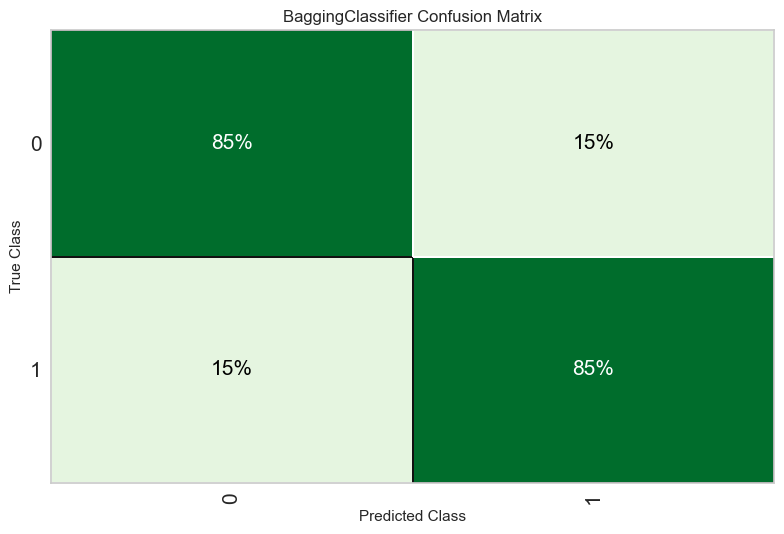

In [25]:
tuned_boosted_lightgbm = tune_model(boosted_lightgbm, optimize = 'Prec.')
plot_model(tuned_boosted_lightgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

## Plot model

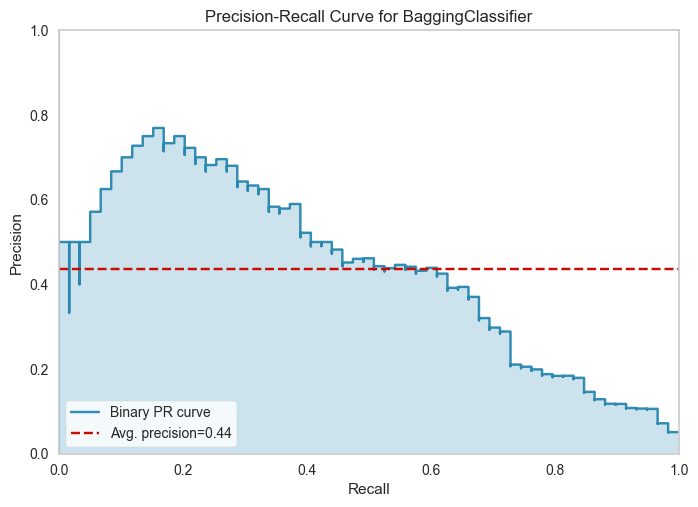

In [23]:
plot_model(boosted_lightgbm, plot = 'pr')

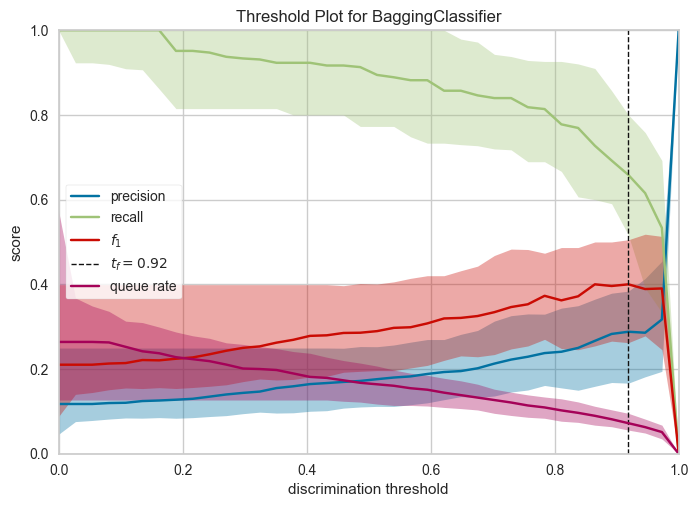

In [24]:
plot_model(boosted_lightgbm, plot = 'threshold')

## Interprete Model

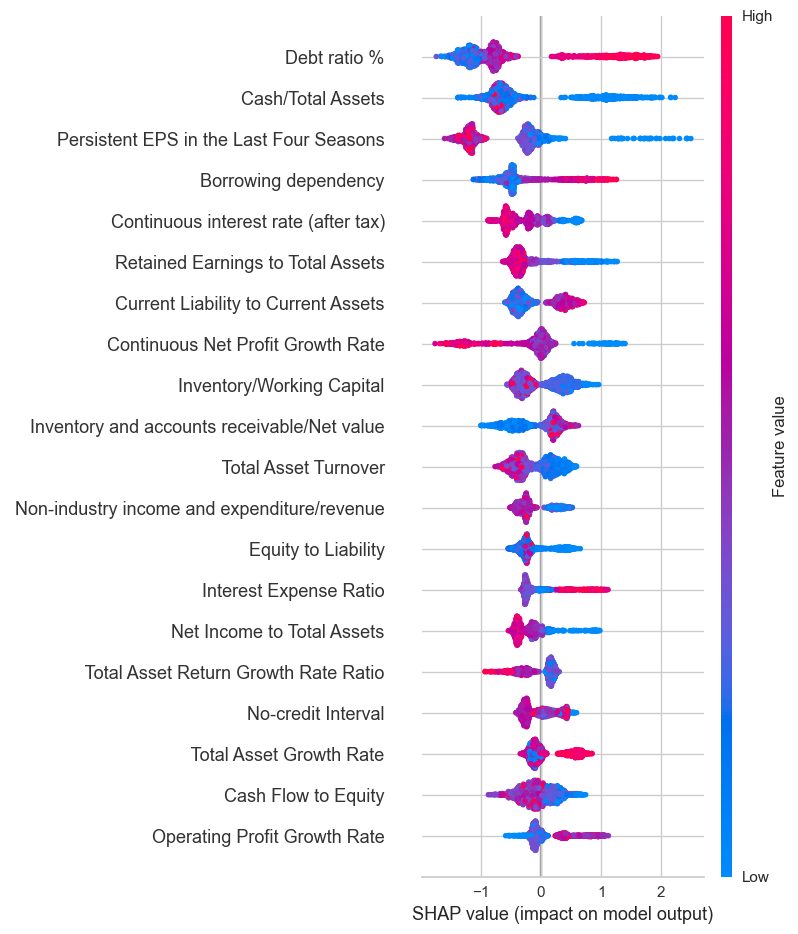

In [26]:
# summary plot
interpret_model(lightgbm)

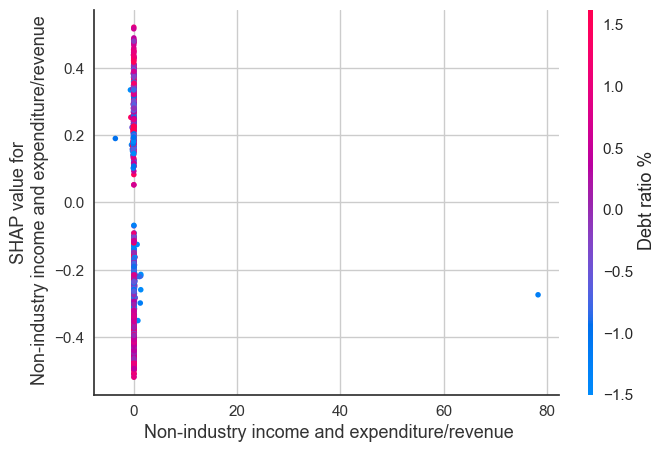

In [27]:
# correlation plot
interpret_model(lightgbm, plot = 'correlation')

# Evaluation

## evaluate unseen data

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8622,0.9420,0.8636,0.1727,0.2879,0.2474,0.3486


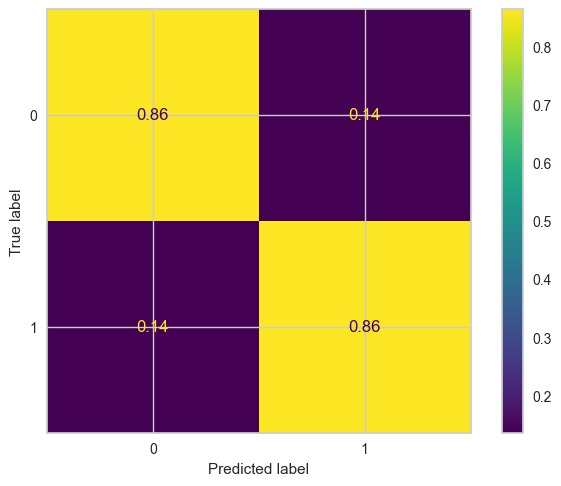

In [47]:
unseen_predictions = predict_model(boosted_lightgbm, data=data_unseen)
cm = confusion_matrix(unseen_predictions["Bankrupt?"], unseen_predictions["Label"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## hotfix

<AxesSubplot: xlabel='Label', ylabel='Score'>

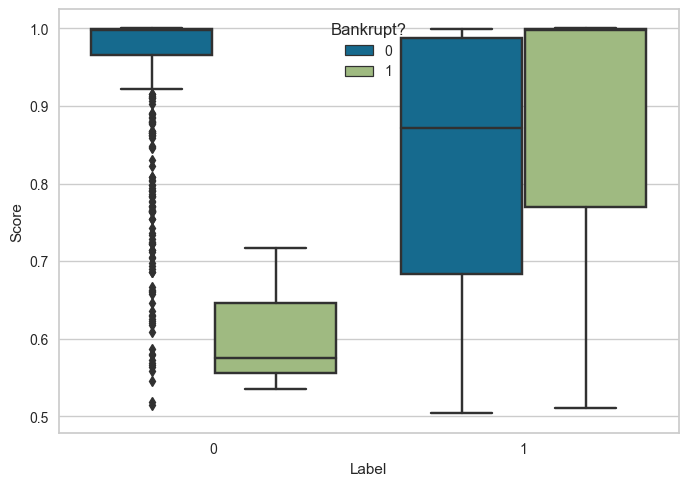

In [48]:
sns.boxplot(x = unseen_predictions["Label"],
            y = unseen_predictions["Score"],
           hue = unseen_predictions["Bankrupt?"])

In [49]:
unseen_predictions.loc[(unseen_predictions["Label"] == 0) & (unseen_predictions["Score"] < 0.75), "Filtered_label"] = 1
# unseen_predictions.loc[(unseen_predictions["Label"] == 1) & (unseen_predictions["Score"] < 0.75), "Filtered_label"] = 0
unseen_predictions.Filtered_label.fillna(unseen_predictions.Label, inplace=True)

Hotfix accuracy:  0.8035190615835777


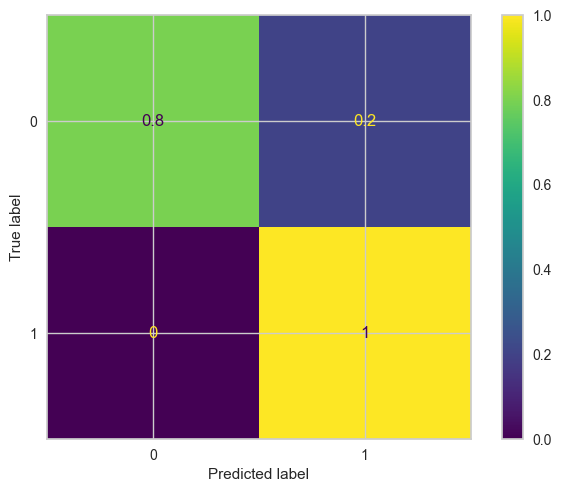

In [50]:
cm = confusion_matrix(unseen_predictions["Bankrupt?"], unseen_predictions["Filtered_label"], normalize="true")
print("Hotfix accuracy: ", accuracy_score(unseen_predictions["Bankrupt?"], unseen_predictions["Filtered_label"]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## save model

In [51]:
save_model(boosted_lightgbm,'saved_models/lightgbm_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[' ROA(C) before '
                                                           'interest and '
                                                           'depreciation before '
                                                           'interest',
                                                           ' ROA(A) before '
                                                           'interest and % '
                                                           'after tax',
                                                           ' ROA(B) before '
                                                           'interest and '
 